# Smoothed Thermostat

(this is the same notebook as Termostat, except that here the input script is not manually smoothed, instead the smoothing happens automatically)

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} -k \cdot \textit{temp} + h \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              -k \cdot \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

I generate temperature trajectories for $tOn =, tOff=, k=, h=, \epsilon=$ and try to synthesize $tOn, tOff$ using as loss the log-likelihood over trajectories.

In [34]:
from sogaPreprocessor import *
from producecfg import *
from libSOGAsmoother import *
from time import time

torch.set_default_dtype(torch.float64)

### Original model

In [35]:
def orig_model(T=10, init_T=17., tOn=18, tOff=20, k=0.01, h=0.5, eps=0.5):
    traj = torch.zeros(T)
    isOn = False
    traj[0] = 16.
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
    
    for i in range(1,T):
        
        #update temperature
        if isOn:
            traj[i] = traj[i-1] -k*traj[i-1] + h + noise.rsample() 
        else:
            traj[i] = traj[i-1] -k*traj[i-1] + noise.rsample() 

        # update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True
            
    return traj        

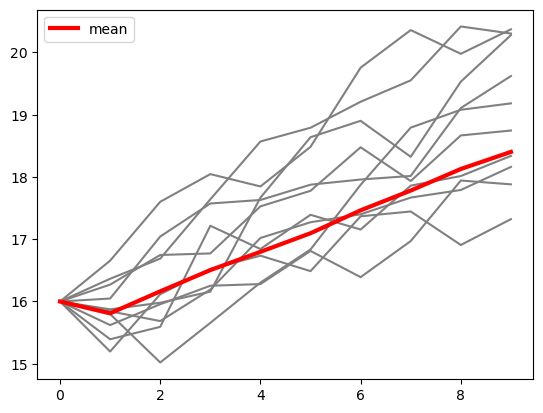

In [36]:
# generation of a set of trajectories

import matplotlib.pyplot as plt

traj_set = []
for _ in range(100):
    traj_set.append(orig_model())
traj_set = torch.vstack(traj_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

### SOGA program

In [37]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/ThermostatNoSmooth.soga')
cfg = produce_cfg(compiledFile)

pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA_smooth(cfg, params_dict)

In [38]:
output_dist.gm.mean()

tensor([16.0000, 15.8400, 15.9943, 16.2172, 16.4707, 16.7413, 17.0222, 17.3097,
        17.6012, 17.8950, 18.4812, 18.4812,  0.8857, 18.4812],
       grad_fn=<SumBackward1>)

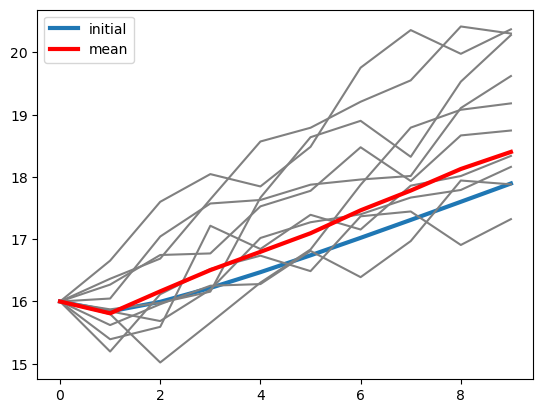

In [39]:
import matplotlib.pyplot as plt

y_init = output_dist.gm.mean()[:10].detach()
plt.plot(range(10), y_init, lw=3, label='initial')

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

In [40]:
def neg_log_likelihood(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[:, idx].unsqueeze(0), idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

neg_log_likelihood(traj_set, output_dist)
        

tensor(727.2419, grad_fn=<NegBackward0>)

In [41]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)
pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

total_start = time()

for i in range(50):

    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA_smooth(cfg, params_dict)

    loss = neg_log_likelihood(traj_set, current_dist)

    # Backpropagate
    loss.backward()
    
    optimizer.step()

    
    # Print progress
    if i % 10 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

total_end = time()

print('Optimization performed in ', round(total_end-total_start, 3))


tOff: 22.0499999998802 tOn: 16.049999999997908  loss: 727.2419413917576
tOff: 22.538172370354147 tOn: 16.492389584060554  loss: 671.0040395482915
tOff: 22.96741002505314 tOn: 16.7575374217613  loss: 664.3736004293118
tOff: 23.3038112226833 tOn: 16.89269458164708  loss: 663.0066087407139
tOff: 23.549161933046204 tOn: 16.97559973282716  loss: 662.2785861945441
Optimization performed in  48.182


In [42]:
params_dict

{'tOff': tensor(23.7102, requires_grad=True),
 'tOn': tensor(17.0324, requires_grad=True)}

In [43]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/ThermostatNoSmooth.soga')
cfg = produce_cfg(compiledFile)
output_dist = start_SOGA_smooth(cfg, params_dict)

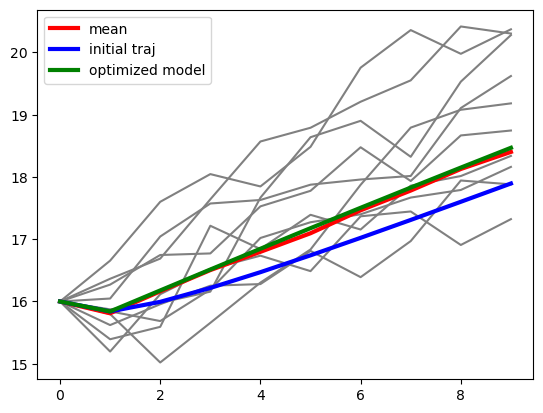

In [44]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')

plt.plot(range(10), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(10), output_dist.gm.mean()[:10].detach(), lw=3, color='green', label='optimized model')

plt.legend()